# Denoising Autoencoder

My first attempts at designing a deep learning based image denoiser, using convolutional neural networks without integrating generative adversarial networks

In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import tensorflow as tf
import tensorflow_hub as hub
from keras import losses, Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Input, \
MaxPooling2D, Add, BatchNormalization, LeakyReLU, Reshape, Flatten, Dense
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error

2022-07-25 16:09:10.128799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Set number of GPUs to be used
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0],'GPU')

In [3]:
# Import image set as numpy arrays. For more info on converting images to numpy arrays, 
# refer to imageprocessing/image data.ipynb
master_dir = '/gpfs_projects/seif.younis/NIH Chest X-rays/numpy_arrays/'

train = np.load(master_dir + 'train.npy')
test = np.load(master_dir + 'test.npy')

display(test.shape)
display(train.shape)

# train = train.astype('float32') / 255.
# test = test.astype('float32') / 255.

(2000, 128, 128, 1)

(84999, 128, 128, 1)

In [4]:
# Function to normalize image pixel values in dataset
def adjust_images(images, newRange=(0, 1)):
    for idx, image in enumerate(images):
        # Get max and min pixel values
        min, max = np.amin(image), np.amax(image)

        # Scale between 0 and 1 and invert pixel values
        scale = 1 - (image - min) / (max - min)

        if newRange != (0, 1):
            # Scale to a different range.
            scale = scale * (newRange[1] - newRange[0]) + newRange[0]
            scale /= 255.

        # Invert pixel values of each image and normalize to between 0 and 1
        images[idx] = scale

    return images

def get_pixel_min_and_max(images):
    return np.min(images), np.max(images)

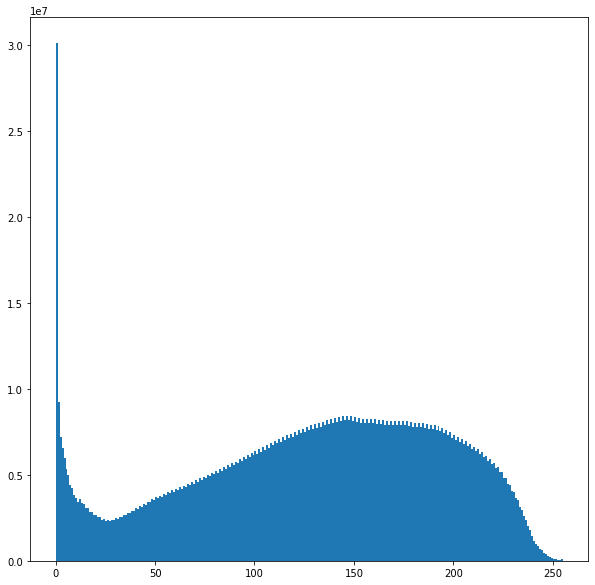

array([30084529.,  9224267.,  7213920.,  6540413.,  5952496.,  5332701.,
        4965430.,  4405173.,  4238914.,  3797841.,  3648781.,  3403916.,
        3569512.,  3336069.,  3307596.,  3086866.,  3055881.,  2840383.,
        2848844.,  2660971.,  2681525.,  2519980.,  2532488.,  2388037.,
        2404646.,  2316423.,  2369638.,  2302273.,  2393623.,  2355832.,
        2466913.,  2435913.,  2562525.,  2535226.,  2671006.,  2648032.,
        2787348.,  2763673.,  2914682.,  2889827.,  3047862.,  3020298.,
        3172704.,  3141440.,  3306868.,  3264282.,  3437125.,  3390457.,
        3562550.,  3515799.,  3679847.,  3622816.,  3792566.,  3728784.,
        3900603.,  3832197.,  4006435.,  3930316.,  4103234.,  4021126.,
        4192061.,  4106628.,  4278373.,  4197120.,  4374564.,  4284257.,
        4472647.,  4380414.,  4570422.,  4480815.,  4675256.,  4585470.,
        4782867.,  4687211.,  4891996.,  4796550.,  5002445.,  4903938.,
        5116228.,  5018423.,  5233820.,  5125656., 

In [6]:
# Generate histogram of pixel value distribution
both = np.concatenate((train, test))
both = both.flatten()
plt.figure(figsize=(10, 10))
(n, bins, patches) = plt.hist(both, bins=range(0,256))
plt.show() 
display(n)

In [5]:
# Normalize pixel values to between the values specified
train = adjust_images(train, (2, 250))
test = adjust_images(test, (2, 250))

Loss functions are integral to training our models. But some losses are themselves the output of neural networks, including structural similarity and VGG loss.



## Structural Similarity Loss

In [6]:
# Structural Similarity Loss

# Get min and max pixel values
min_train, max_train = get_pixel_min_and_max(train)
min_test, max_test = get_pixel_min_and_max(test)

if min_test == min_train and max_test == max_train:
    min = min_test 
    max = max_test
else:
    raise Exception("Min and max pixel values aren't the same for testing and \
    training sets")

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max - min))

## VGG Loss

In [ ]:
#Load VGG model
vgg = tf.keras.applications.VGG19(include_top=False, weights=None, 
                                  input_shape = [128,128,1])
vgg.trainable = False
content_layers = 'block5_conv2'

lossModel = Model([vgg.input], vgg.get_layer(content_layers).output, name = 'vggL')

@tf.function()
def lossVGG(X,Y):
    Xt = preprocess_input(X*255)
    Yt = preprocess_input(Y*255)
    vggX = lossModel(Xt)
    vggY = lossModel(Yt)
    return tf.reduce_mean(tf.square(vggY-vggX))

# optimizer = Adam(learning_rate=0.0005)
vgg_loss = [lossVGG]

In [7]:
# Plot training performance
def plot_training_loss(history, title: str):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Add noise to images

In [8]:
noise_factor = 0.4
train_noisy = train + noise_factor * tf.random.normal(shape=train.shape) 
test_noisy = test + noise_factor * tf.random.normal(shape=test.shape) 

train_noisy = tf.clip_by_value(train_noisy, clip_value_min=0., clip_value_max=1.)
test_noisy = tf.clip_by_value(test_noisy, clip_value_min=0., clip_value_max=1.)

2022-07-25 16:09:47.120764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 16:09:48.262718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


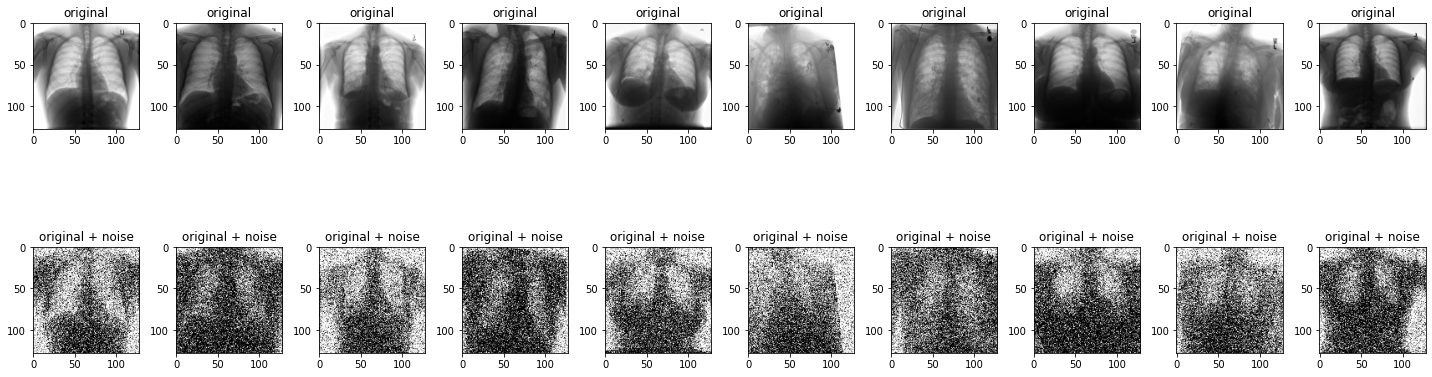

In [9]:
n = 10
fig, ax = plt.subplots(2, n, figsize=(20,7))
for i in range(n):
    # Display original
    ax[0, i].set_title("original")
    ax[0, i].imshow(tf.squeeze(train[i]), cmap="gray")

    # Display original + noise
    ax[1, i].set_title("original + noise")
    ax[1, i].imshow(tf.squeeze(train_noisy[i]), cmap="gray")

plt.tight_layout()
plt.show()

This model was taken from this autoencoder <a href="https://www.tensorflow.org/tutorials/generative/autoencoder?hl=en">tutorial</a> on TensorFlow's website.

In [24]:
def DenoiseTfTutorial(img_res: int):
    input = Input(shape=(img_res, img_res, 1))

    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(x)

    # Decoder
    x = Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = Model(input, x)
    autoencoder.compile(optimizer="adam", loss=SSIMLoss)
    autoencoder.summary()

    return autoencoder

This next model was taken from another autoencoder <a href="https://keras.io/examples/vision/autoencoder/">tutorial</a>, this time from the Keras website

In [25]:
def DenoiseKerasTutorial(img_res: int):
    input = Input(shape=(img_res, img_res, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    # Autoencoder
    autoencoder = Model(input, x)
    autoencoder.compile(optimizer="adam", loss=SSIMLoss)
    autoencoder.summary()

    return autoencoder

Following that, this model was created using this research paper from Simon Fraser University as a reference.

- Gondara, Lovedeep. “Medical Image Denoising Using Convolutional Denoising Autoencoders.” 2016 IEEE 16th International Conference on Data Mining Workshops (ICDMW), 2016, https://doi.org/10.1109/icdmw.2016.0041. 

In [26]:
def DenoiseFraser(img_res: int, loss):
    input = Input(shape=(img_res, img_res, 1))

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2 ,2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder
    autoencoder = Model(input, x)
    autoencoder.compile(optimizer="adam", loss=loss)
    autoencoder.summary()

    return autoencoder

I took this model from an existing implementation of the research presented in this paper.

- J. Dong , XJ. Mao , C. Shen , YB. Yang, Learning Deep Representations Using Convolutional Auto-encoders with Symmetric Skip Connections (2017)



In [10]:
def DenoiseSikka(img_res: int, loss):
    def lrelu_bn(inputs):
        lrelu = LeakyReLU()(inputs)
        bn = BatchNormalization()(lrelu)
        return bn

    input = Input(shape=(img_res, img_res, 1))

    y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(input)
    y = LeakyReLU()(y)
    y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
    y = LeakyReLU()(y)
    y2 = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y)
    y = LeakyReLU()(y2)
    y = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
    y = LeakyReLU()(y)
    y1 = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
    y = LeakyReLU()(y1)
    y = Conv2D(512, (3, 3), padding='same',strides =(2,2))(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), padding='same',strides =(2,2))(y)
    y = LeakyReLU()(y)

    # Flattening for the bottleneck
    vol = y.shape 
    x = Flatten()(y)
    latent = Dense(64,activation='relu')(x) 

    #Decoder
    y = Dense(np.prod(vol[1:]), activation='relu')(latent) # accepting the output from the bottleneck layer
    y = Reshape((vol[1], vol[2], vol[3]))(y) 
    y = Conv2DTranspose(1024, (3,3), padding='same')(y)
    y = LeakyReLU()(y)
    y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2))(y)
    y = LeakyReLU()(y)
    y = Conv2DTranspose(256, (3,3), padding='same',strides=(1,1))(y)
    y= Add()([y1, y]) # remove to run model without skip connections
    y = lrelu_bn(y)  # remove to run model without skip connections
    y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
    y = LeakyReLU()(y) 
    y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2))(y)   
    y= Add()([y2, y]) # remove to run model without skip connections
    y = lrelu_bn(y) # remove to run model without skip connections
    y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2))(y)
    y = LeakyReLU()(y)
    y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2))(y)
    y = LeakyReLU()(y)
    y = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

    autoencoder = Model(input, y)
    autoencoder.compile(optimizer=Adam(0.001,beta_1=0.9), 
                      loss=loss)
    autoencoder.summary() 

    return autoencoder

Here's another model derived from a research paper, this time from the Polytechnic University of Milan, Italy.

- Bonettini, Nicolo, et al. “Hyperspectral X-Ray Denoising: Model-Based and Data-Driven Solutions.” 2019 27th European Signal Processing Conference (EUSIPCO), 2019, https://doi.org/10.23919/eusipco.2019.8903151. 

In [28]:
def DenoiseMilan(img_res: int):
    input = Input(shape=(img_res, img_res, 1))

    # Encoder
    x = Conv2D(32, kernel_size=(5, 5), activation='relu')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D((2 ,2))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D((2 ,2))(x)
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D((2 ,2))(x)

    # Decoder  
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(1, (5, 5), activation='sigmoid')(x)

    autoencoder = Model(input, x)
    autoencoder.compile(optimizer=tf.optimizers.SGD(momentum=0.9, 
                                                learning_rate=0.01, 
                                                nesterov=True),
                      loss=SSIMLoss)
    autoencoder.summary()
    return autoencoder

## Pick a model to use. Adjust variables as necessary

In [ ]:
autoencoder_sikka = DenoiseSikka(128, SSIMLoss)

In [48]:
hist_sikka = autoencoder_sikka.fit(x=train_noisy, y=train,
                                  epochs=25,
                                  batch_size=10,
                                  shuffle=True,
                                  validation_split=0.2)

Epoch 1/25
800/800 [==============================] - 33s 39ms/step - loss: 0.2658 - val_loss: 0.2510
Epoch 2/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2393 - val_loss: 0.2408
Epoch 3/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2298 - val_loss: 0.2235
Epoch 4/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2252 - val_loss: 0.2202
Epoch 5/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2216 - val_loss: 0.2177
Epoch 6/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2192 - val_loss: 0.2183
Epoch 7/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2165 - val_loss: 0.2183
Epoch 8/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2147 - val_loss: 0.2156
Epoch 9/25
800/800 [==============================] - 31s 39ms/step - loss: 0.2132 - val_loss: 0.2127
Epoch 10/25
800/800 [==============================] - 31s 39ms/step - loss: 0.211

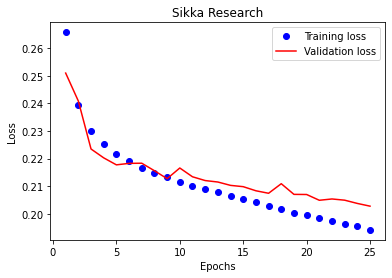

In [49]:
plot_training_loss(hist_sikka, "Sikka Research")

In [50]:
decoded_sikka = autoencoder_sikka.predict(test_noisy)

63/63 [==============================] - 1s 10ms/step


In [51]:
def plot_image_loss(decoded_imgs, title):
    noisy_loss = []
    denoised_loss = []

    for i in range(0,len(test)):
        original = test[i]
        noisy = test_noisy[i].numpy()
        denoised = decoded_imgs[i]
        
        # original = test[i].flatten()
        # noisy = test_noisy[i].numpy().flatten()
        # denoised = decoded_imgs[i].flatten()

        ssim_noisy = SSIMLoss(original, noisy)
        ssim_denoised = SSIMLoss(original, denoised)
        noisy_loss.append(ssim_noisy)
        denoised_loss.append(ssim_denoised)

    plt.plot(range(0, len(test)), noisy_loss, label='Noisy Image Loss')
    plt.plot(range(0, len(test)), denoised_loss, label='Denoised Image Loss')
    plt.title(title)
    plt.xlabel('Image Number')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

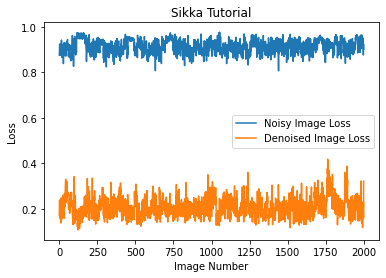

In [52]:
plot_image_loss(decoded_sikka, "Sikka Tutorial")

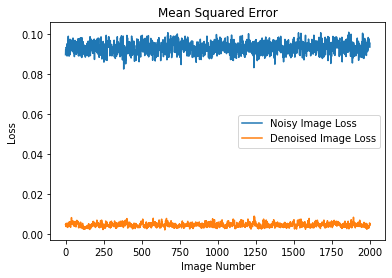

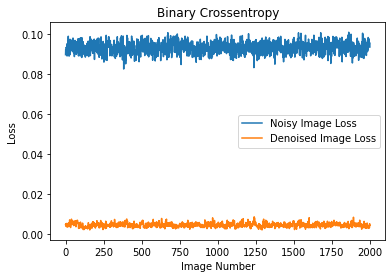

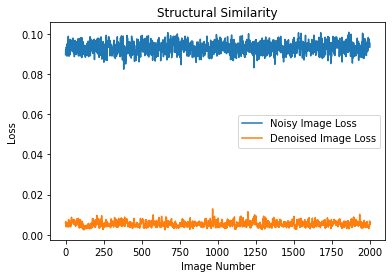

In [ ]:
plot_image_loss(decoded_mse, "Mean Squared Error")
plot_image_loss(decoded_crossentropy, "Binary Crossentropy")
plot_image_loss(decoded_ssim, "Structural Similarity")

In [43]:
def plot_image_reconstruction(decoded_imgs, title):
    n = 3
    fig, ax = plt.subplots(1, n, figsize=(10,10))
    fig.suptitle(title, y=0.7, fontsize=16)
    for i in range(n):
        # display reconstruction
        ax[i].set_title("reconstructed")
        ax[i].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')

    plt.tight_layout()
    plt.show()

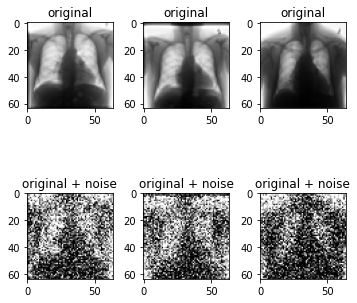

In [53]:
n = 3
fig, ax = plt.subplots(2, n, figsize=(5,5))
for i in range(n):
    # display original
    ax[0, i].set_title("original")
    ax[0, i].imshow(tf.squeeze(test[i]), cmap='gray')

    # display original + noise
    ax[1, i].set_title("original + noise")
    ax[1, i].imshow(tf.squeeze(test_noisy[i]), cmap='gray')

plt.tight_layout()

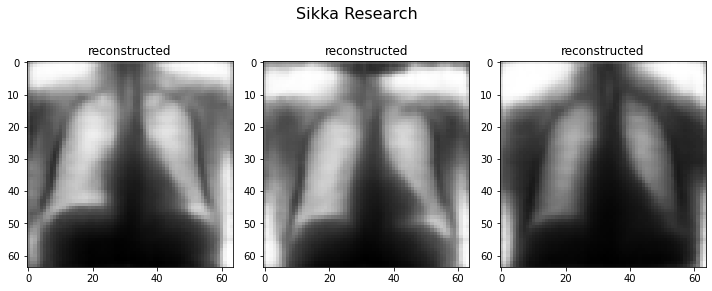

In [54]:
plot_image_reconstruction(decoded_sikka, "Sikka Research")

# Generative Adversarial Networks

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
def preprocess_image(hr_image):
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image, cmap='gray')
  plt.axis("off")
  plt.title(title)

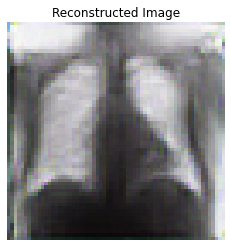

In [ ]:
reconstruction = decoded_fraser[0] * 255.
# reconstruction = cv2.cvtColor(reconstruction, cv2.COLOR_GRAY2BGR)

image = preprocess_image(reconstruction)
plot_image(tf.squeeze(image), title="Reconstructed Image")

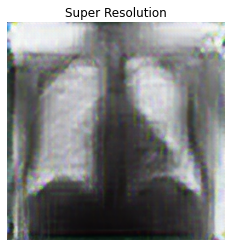

In [ ]:
fake_image = model(image)
fake_image = tf.squeeze(fake_image)
plot_image(tf.squeeze(fake_image), title="Super Resolution")

In [ ]:
fake_image.shape

TensorShape([256, 256, 3])

# References
1. <a href="https://stackoverflow.com/questions/48109228/normalizing-data-to-certain-range-of-values">Image Pixel Normalization</a>
2. <a href="https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras">Structural Similarity Loss</a> 